In [28]:
import warnings
import os
import itertools
import pandas as pd
import numpy as np
from random import random, gauss
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [29]:
# general settings
class CFG:
    data_folder = './../data/NSW/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

# 

In [30]:
# Adjusted code to load the DataFrame
df = pd.read_csv(
    os.path.join(CFG.data_folder, 'final_df.csv'),
    index_col=0,
    parse_dates=True  # Ensure the index is parsed as datetime
)

# Clean up column names if necessary
df.columns = df.columns.str.strip()

# Ensure the index is named 'date'
df.index.name = 'date'

# Select the 'TOTALDEMAND' column
df = df[['TOTALDEMAND']]

# Step 1: Find the latest date in your index
latest_date = df.index.max()

# Step 2: Calculate the cutoff date (12 months earlier)
cutoff_date = latest_date - pd.DateOffset(months=12)

# Step 3: Select rows from the last 12 months
subset_df = df.loc[cutoff_date:]
df.head()

,TOTALDEMAND
date,
2010-01-01 00:30:00,7809.31
2010-01-01 01:00:00,7483.69
2010-01-01 01:30:00,7117.23
2010-01-01 02:00:00,6812.03
2010-01-01 02:30:00,6544.33


<Axes: xlabel='date'>

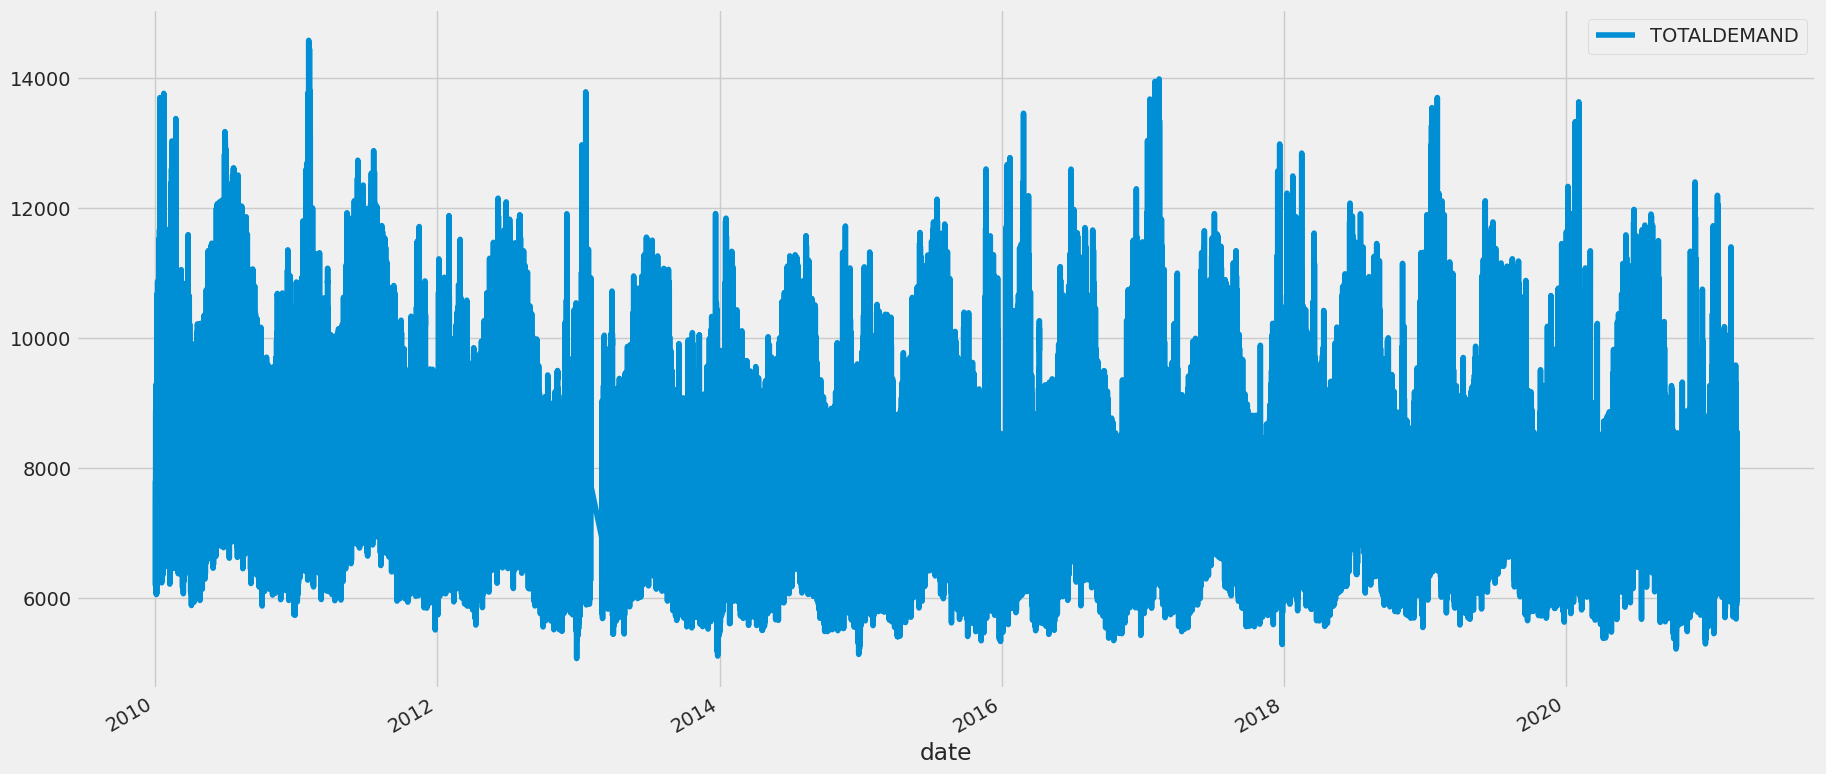

In [31]:
df.plot()

start with decomposition to get an understanding of the dynamics

# 24 hour decomposition

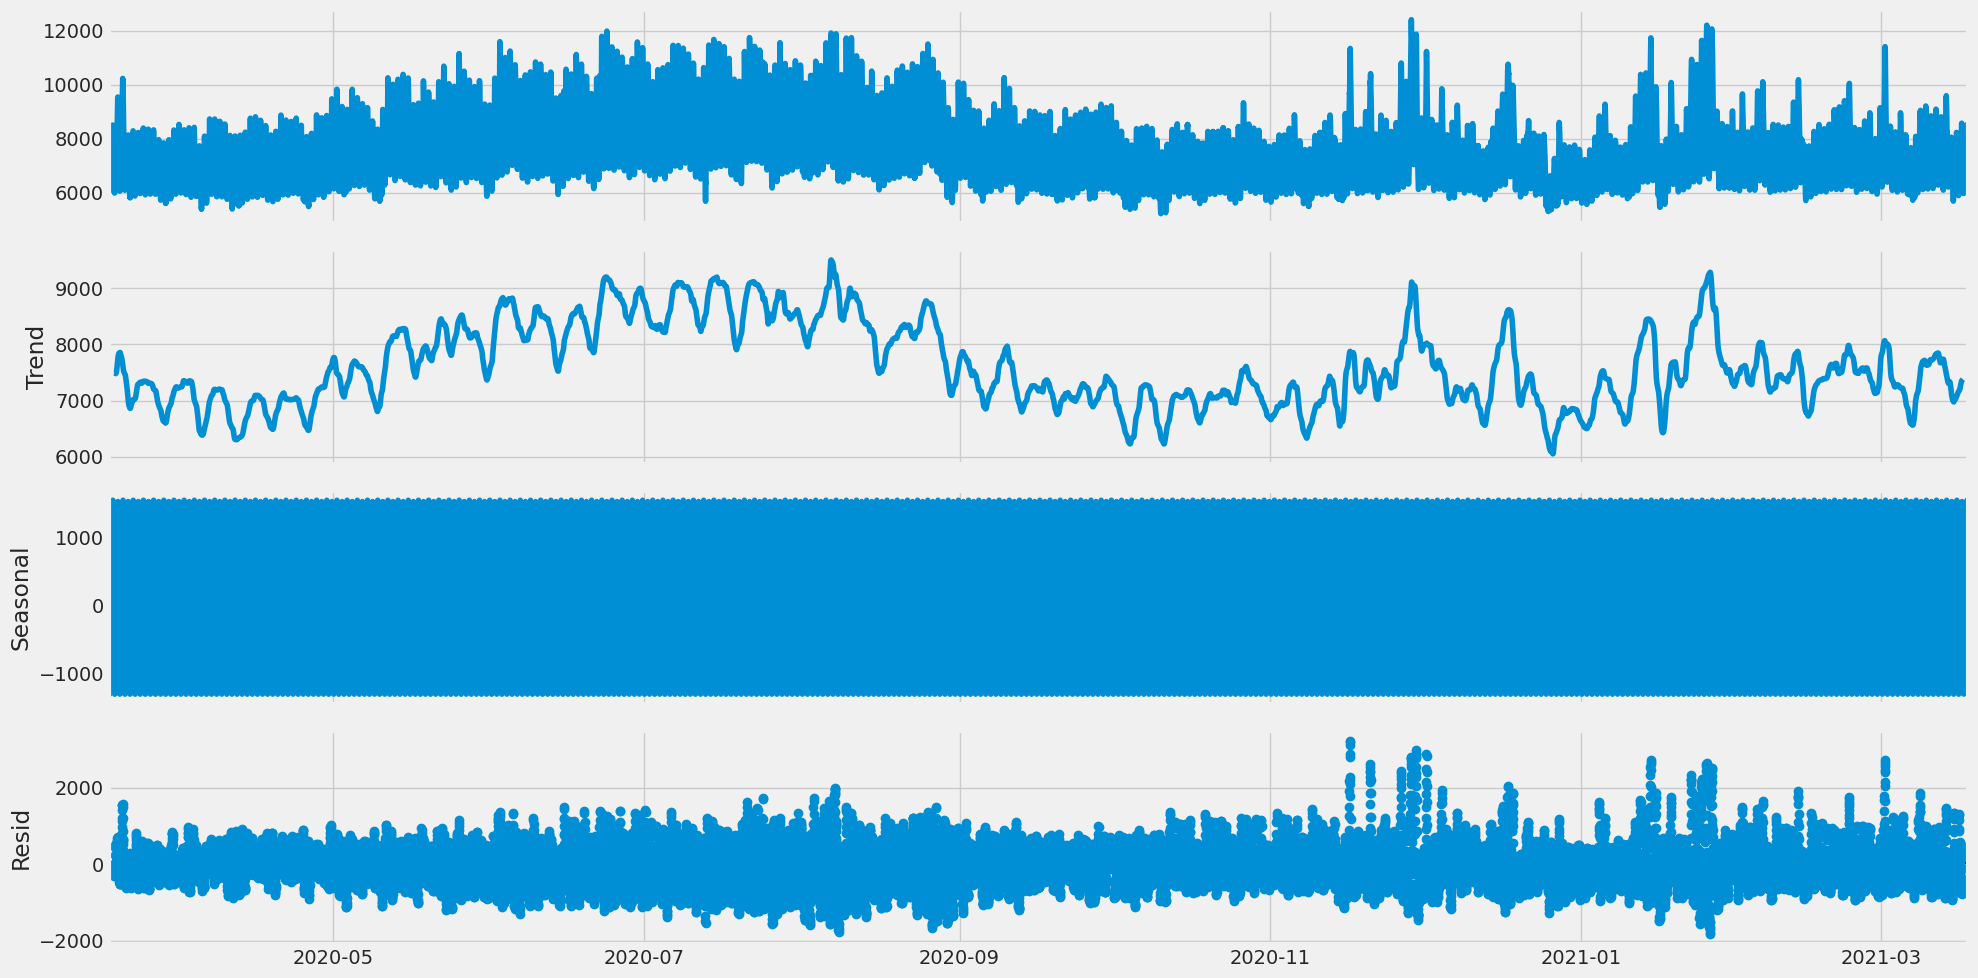

CPU times: user 641 ms, sys: 133 ms, total: 774 ms
Wall time: 578 ms


In [32]:
%%time
daily_decomp = sm.tsa.seasonal_decompose(
    subset_df, 
    period=96
)
fig1 = daily_decomp.plot()
plt.show()

# 7 day decomposition

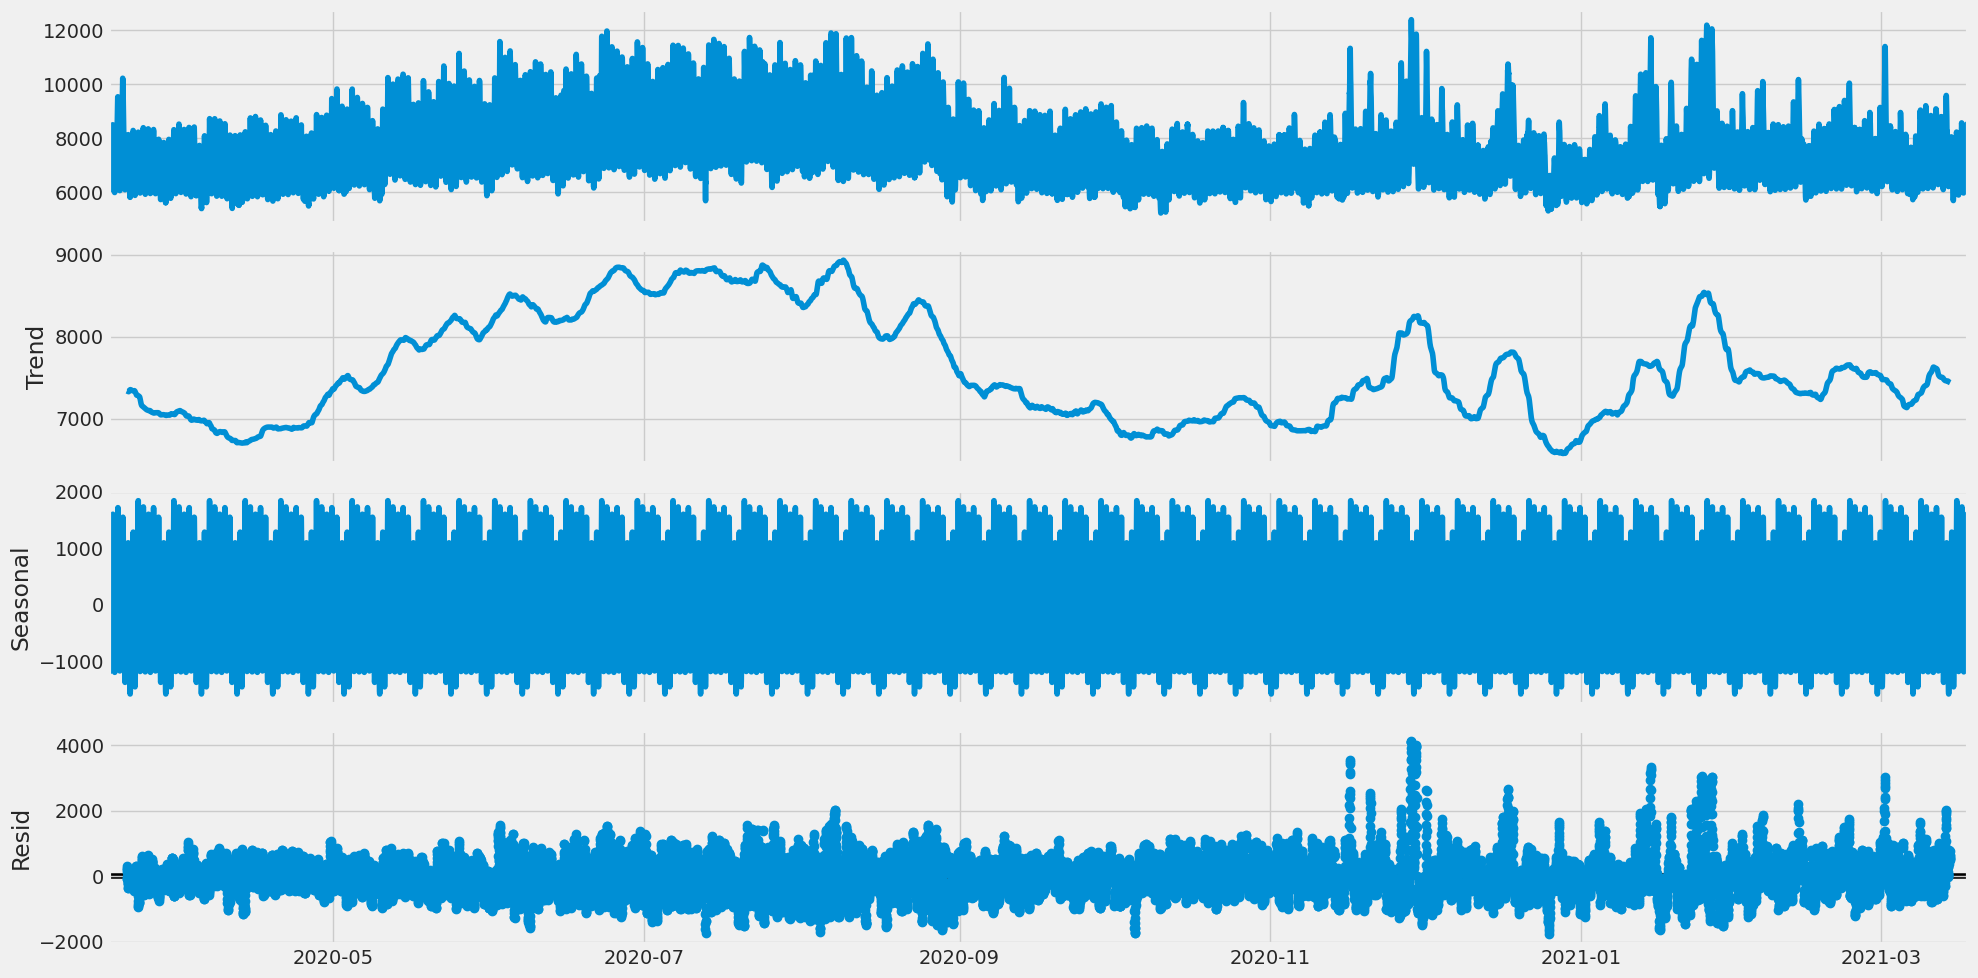

CPU times: user 621 ms, sys: 157 ms, total: 778 ms
Wall time: 582 ms


In [33]:
%%time
week_decomp = sm.tsa.seasonal_decompose(
    subset_df, 
    period=336
)
fig2 = week_decomp.plot()
plt.show()

# 3 month decomposition

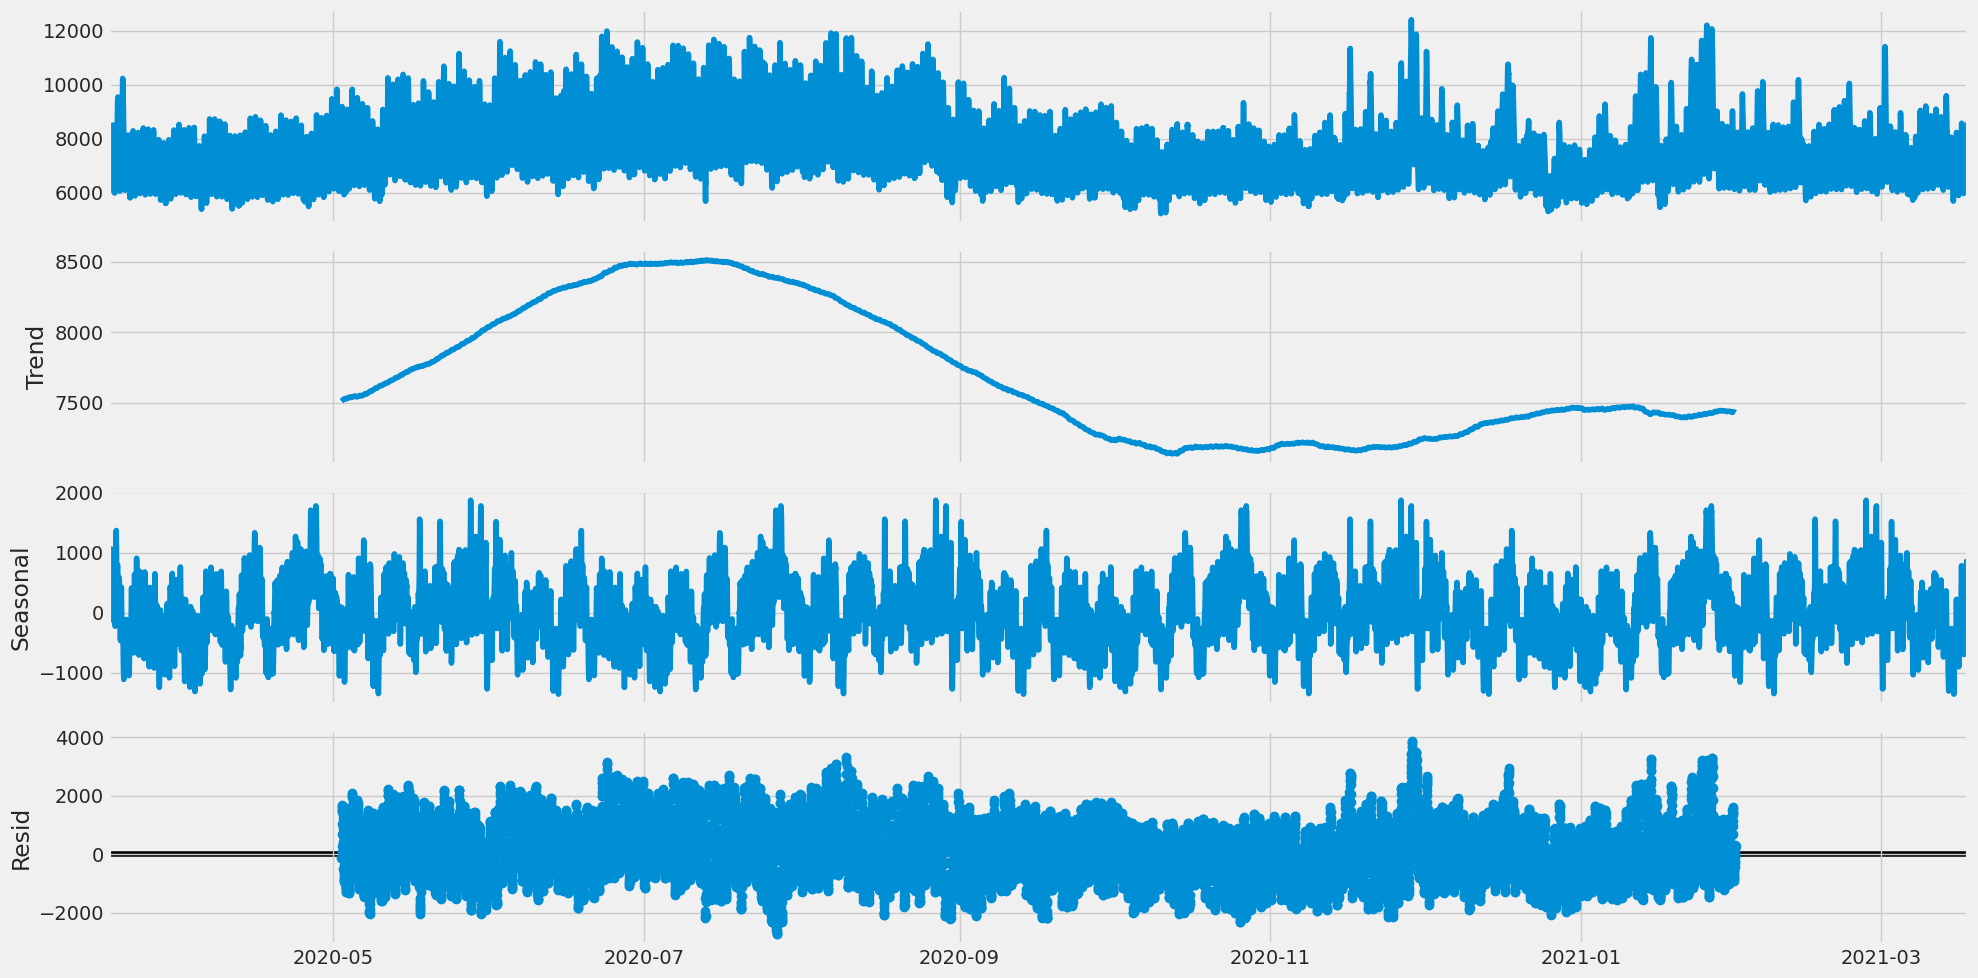

CPU times: user 672 ms, sys: 169 ms, total: 841 ms
Wall time: 645 ms


In [34]:
%%time
three_month_decomp = sm.tsa.seasonal_decompose(
    subset_df, 
    period=4383
)
fig3 = three_month_decomp.plot()
plt.show()

split data into test / train

In [35]:
cutoff_date = '2021-12-31'  # fix_me
xtrain, xvalid  = df.loc[df.index <= cutoff_date], df.loc[df.index > cutoff_date]
print(xtrain.shape, xvalid.shape)

(194589, 1) (0, 1)


# fit the holt winders model

In [36]:
fit1 = ExponentialSmoothing(
    xtrain['value'].values, 
    seasonal_periods=48, 
    trend='mul', 
    seasonal='mul'
)
fit1 = fit1.fit(use_boxcox=True)

KeyError: 'value'

examine the parameters

In [ ]:
fit1.params_formatted

# what do the residuals look like?

In [ ]:
prediction = fit1.forecast(len(xvalid)).copy()

xresiduals = xvalid['value'] - prediction
plot_acf(xresiduals, lags=25)
print()

# PACF

In [ ]:
plot_pacf(
    xresiduals, 
    lags=25
)
print()

# prediction plot

In [ ]:
xvalid['prediction'] = prediction
xvalid.plot()